In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
#load and split the dataset
df = pd.read_csv("/content/sample_data/movie.csv.zip")
train_data, test_data, train_label, test_label =  train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)
df = df.iloc[:64]

In [5]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#sentences are broken into words and they are converted to tokens.
#Next,  special tokens like [CLS] and [SEP] - they are added at the beginning and the end of each sentence which is converted to list of tokens

bert_model = BertModel.from_pretrained('bert-base-uncased')
#there are two types - bert-base and bert-large, the first has 12 transformer layers and the second with 24
#we use bert-base since it is smaller and faster and usually enough for most tasks
#the 'uncased' part refers to all the texts being converted to lower case

bert_model.to(device)

bert_model.eval()
#this part ensures that no parameters of the bert model is updated - what the statement of the milestone mentioned as 'no fine-tuning'


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [6]:
#custom dataset
class MovieReviewDataset(Dataset):

  def __init__(self, texts, labels, tokenizer, max_length):
    self.texts = texts.tolist()
    self.labels = labels.tolist()
    self.tokenizer = tokenizer
    self.max_len = max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, index):

    encoded = self.tokenizer(
        self.texts[index],        #extracts the index-th review
        truncation=True,          #cuts short the review if it exceeds the max length
        padding='max_length',     #padding (in order to ensure that all the reviews are of the same size, fillers of numbers '0' are added this is called padding)
        max_length=self.max_len,
        return_tensors='pt'       #output will be a pytorch tensor
    )

    input_ids = encoded['input_ids'].squeeze(0)
    #encoder['input_ids'] returns a 2d tensor of size [1,max_len] containing numerical token ids of the texts after being passed through bert.
    #the .squeeze(0) converts it to a 1d tensor, the 0 is to specify that it removes the 0th dimension

    attention_mask = encoded['attention_mask'].squeeze(0)
    #this is to tell the model which are real elements and which are paddings
    #encoded['attention_mask'] returns a 2d tensor containing 0s and 1s where 0 stands for the padded elements and 1 for the real ones

    label = torch.tensor(self.labels[index], dtype = torch.long)
    #converting the label of that particular review to a tensor

    return input_ids, attention_mask, label


In [15]:
#creating datasets and dataloaders
max_length = 128

train_dataset = MovieReviewDataset(train_data, train_label, tokenizer, max_length)
test_dataset = MovieReviewDataset(test_data, test_label, tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

In [12]:
#defining the LSTMClassifier
#LSTM - type of RNN used to calculate sequential data (sequential data - order matters)

class LSTMClassifier(nn.Module):

  def __init__(self, hidden_dim = 128, num_classes = 2):  #num_classes refers to the number of output classes - here it is 2 -> 0 and 1

    super().__init__()  #to call the constructor of the parent class
    self.hidden_dim = hidden_dim
    self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_dim, batch_first=True) #bert computes a vector of dimension 768 for each token
    self.fc = nn.Linear(hidden_dim, num_classes)

  def forward (self, input_ids, attention_mask):

    with torch.no_grad():
      outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
      embeddings = outputs.last_hidden_state  #shape - [batch size, sequence length(number of tokens per review), 768(dimension of the vector representing token)]

    lstm_out, _ = self.lstm(embeddings)
    #shape of lstm_out - [batch size, sequence length, hidden dim], gives the output at each step, i.e for each token
    #'_' contains final hidden and cell states - we're not using that since we have the output at each step anyways

    out = lstm_out[:, 0, :]
    #selecting the hidden state for the first token in each sequence
    #the first token is [CLS] which is supposed to summarize the entire review

    logits = self.fc(out)
    #unnormalized outputs of shape - [batch size, num_classes(2)]

    return logits




In [13]:
#initializing model, loss and optimizer

model = LSTMClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
#training loop
epochs = 5
loss_history = []

for epoch in range(epochs):

  model.train()
  total_loss = 0

  for input_ids, attention_mask, labels in train_loader:

    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(input_ids, attention_mask)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  avg_loss = total_loss / len(train_loader)
  loss_history.append(avg_loss)
  print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")



Epoch 1/5, Loss: 0.4107
Epoch 2/5, Loss: 0.3986
Epoch 3/5, Loss: 0.3864
Epoch 4/5, Loss: 0.3778
Epoch 5/5, Loss: 0.3654


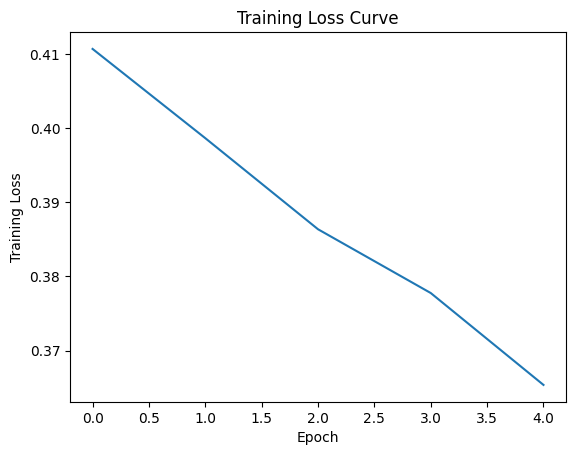

In [18]:
#plotting training loss
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.show()

In [19]:
#evaluation

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask)  #output shape is [batch size, 2]

        _, predicted = torch.max(outputs, 1)
        #torch.max returns the max value in each row and the indices of the max value

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8119


In [20]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True \
  --ClearMetadataPreprocessor.clear_cell_metadata=True \
  --ClearMetadataPreprocessor.clear_notebook_metadata=True \
  --inplace --to notebook "Milestone2-3_Sentiment_Analysis_Using_LSTM.ipynb"


[NbConvertApp] WARNING | pattern 'Milestone2-3_Sentiment_Analysis_Using_LSTM.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp